In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

## Pandas Train Data

In [2]:
dataframe_train = pd.read_csv('../dataset/train_data-2015-2016.csv')
dataframe_train = dataframe_train.fillna(method='ffill')
del dataframe_train['Date']
dataframe_train.head()

,vix(t-1),vbx(t-1),gold(t-1),google(t-1),ibm(t-1),microsoft(t-1),apple(t-1),amazon(t-1),jnj(t-1),starbucks(t-1),btc(t-1),vfinx
0,14.16,9.397634,6.670915,532.338440,125.478996,43.304543,26.250975,326.000000,92.316292,36.458092,379.244995,170.857498
1,12.85,9.371768,6.412894,532.288574,126.356789,43.162029,26.150595,326.309998,92.726479,36.241657,381.315002,171.545120
2,12.50,9.371768,6.627911,529.865234,127.793831,42.823586,26.447168,316.500000,92.051407,36.286743,375.010010,171.348679
3,12.38,9.380388,6.429019,535.838867,127.428726,43.500492,26.346790,316.929993,91.914658,36.665535,369.604004,171.634415
4,11.89,9.354521,6.214004,523.821838,126.822800,43.126408,26.235003,312.630005,92.726479,37.684635,376.854004,170.411041


## Pandas Test Data

In [3]:
dataframe_pred = pd.read_csv('../dataset/predict_data-2017.csv')
dataframe_pred = dataframe_pred.fillna(method='ffill')
del dataframe_pred['Date']
dataframe_pred.head()

,vix(t-1),vbx(t-1),gold(t-1),google(t-1),ibm(t-1),microsoft(t-1),apple(t-1),amazon(t-1),jnj(t-1),starbucks(t-1),btc(t-1),vfinx
0,14.04,9.679321,9.725278,771.820007,140.621094,58.413239,27.470144,749.869995,104.234779,51.476116,961.237976,194.644714
1,12.85,9.679321,9.974802,786.140015,141.637695,58.826855,27.548414,753.669983,104.804771,51.318497,1043.839966,195.803223
2,11.85,9.688409,9.980888,786.900024,143.391296,58.563644,27.517582,757.179993,104.632874,51.911888,1154.729980,195.653763
3,11.67,9.733855,10.571219,794.020020,142.916901,58.563644,27.657520,780.450012,105.727615,52.347645,1013.380005,196.401154
4,11.32,9.697502,10.303443,806.150024,143.620056,59.071262,27.965857,795.989990,105.220963,52.968849,902.200989,195.700455


## Normalize test

In [4]:
from scipy import stats
print(stats.shapiro(dataframe_train['vix(t-1)'].values))
print(stats.shapiro(dataframe_train['vbx(t-1)'].values))

ShapiroResult(statistic=0.8493280410766602, pvalue=5.70727864499684e-22)
ShapiroResult(statistic=0.8939709067344666, pvalue=1.4323610447430018e-18)


## Min Max Scaler

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(dataframe_train[:250])
scaled_train = scaler.fit_transform(dataframe_train[:250])
scaled_train = Variable(torch.tensor(scaled_train).type(torch.FloatTensor))

scal = MinMaxScaler()
scal = scaler.fit(dataframe_pred[:250])
scaled_test = scal.fit_transform(dataframe_pred[:250])
scaled_test = Variable(torch.tensor(scaled_test).type(torch.FloatTensor))



In [6]:
import torch.nn as nn
losses = []

model = nn.Sequential(torch.nn.Linear(12,1))
optimizer = torch.optim.SGD(model.parameters(), lr=0.09)
loss_function = torch.nn.MSELoss()

for epoch in range(0,100):
    prediction = model(scaled_train)
    loss = loss_function(prediction,scaled_test[:,11])
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(loss)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([250])) that is different to the input size (torch.Size([250, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.4436, grad_fn=<MseLossBackward>)
tensor(0.0754, grad_fn=<MseLossBackward>)
tensor(0.0705, grad_fn=<MseLossBackward>)
tensor(0.0684, grad_fn=<MseLossBackward>)
tensor(0.0673, grad_fn=<MseLossBackward>)
tensor(0.0667, grad_fn=<MseLossBackward>)
tensor(0.0663, grad_fn=<MseLossBackward>)
tensor(0.0660, grad_fn=<MseLossBackward>)
tensor(0.0658, grad_fn=<MseLossBackward>)
tensor(0.0657, grad_fn=<MseLossBackward>)


## Show Loss

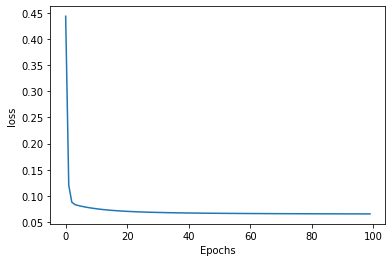

In [7]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

## Draw Data(Scaler)

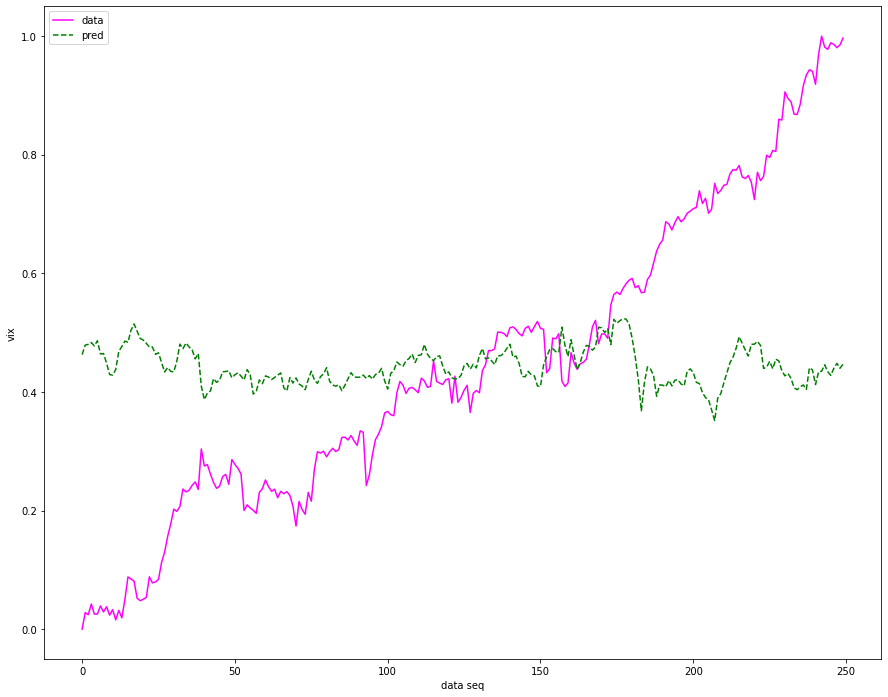

In [8]:
plt.figure(figsize=(15,12))
x_plot, = plt.plot(scaled_test[:,11],'magenta')
y_plot, = plt.plot(prediction.data, 'g--')
plt.xlabel('data seq')
plt.ylabel('vix')
plt.legend([x_plot,y_plot],['data','pred'])
plt.show()

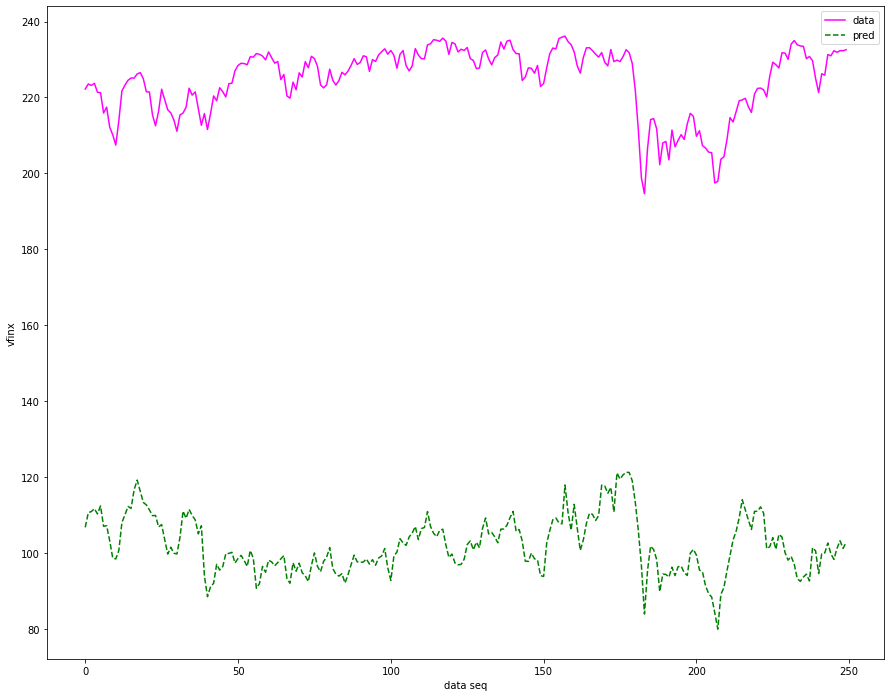

In [9]:
data1 = scaler.inverse_transform(scaled_train)
data2 = np.array(prediction.data)

for i in range(0,250):
    data2[i] = data2[i] * (dataframe_pred['vfinx'].max() - scal.min_[11]) + scal.min_[11]


plt.figure(figsize=(15,12))
x_plot, = plt.plot(data1[:,11],'magenta')
y_plot, = plt.plot(data2, 'g--')
plt.xlabel('data seq')
plt.ylabel('vfinx')
plt.legend([x_plot,y_plot],['data','pred'])
plt.show()